In [1]:
%matplotlib nbagg
%load_ext line_profiler
%load_ext autoreload

In [2]:
import math
import json
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import scipy.sparse
import sparse
import numba
import scipy.io as spio
from scipy.linalg import norm

In [3]:
from libertem import api
from libertem.executor.inline import InlineJobExecutor
from libertem.executor.base import AsyncAdapter
from libertem.common.backend import set_use_cuda, set_use_cpu, get_device_class
from libertem.udf.base import UDFRunner, UDF
from libertem.common.container import MaskContainer
from libertem.masks import circular
from libertem.corrections.coordinates import identity

In [4]:
from ptychography.reconstruction.ssb import SSB_UDF, generate_masks, get_results
from ptychography.reconstruction.common import wavelength, get_shifted

In [5]:
rec_params = {
    'semiconv_pix': 16,
     'cy': 130,
     'cx': 135,
     'U': 80,
     'dpix': [1.0950026e-11, 1.2643999999999998e-11],
     'semiconv': 0.0115,
     'transformation': [[1.0, 0.0], [0.0, 1.0]],
     'shape': [43, 25, 262, 262]
}

In [6]:
semiconv_pix = rec_params['semiconv_pix']
cy = rec_params['cy']
cx = rec_params['cx']
U = rec_params['U']
dpix = rec_params['dpix']
semiconv = rec_params['semiconv']
transformation = np.array(rec_params['transformation'])
# shape = tuple(rec_params['shape'][])
shape = (43, 25, 262, 262)

In [7]:
complex_wave = 10*(2+3j)*circular(
    centerX=cx,
    centerY=cy,
    imageSizeX=shape[3],
    imageSizeY=shape[2],
    radius=semiconv_pix,
    antialiased=True,
)
intensity = np.real(complex_wave*np.conj(complex_wave))

complex_waves = np.broadcast_to(complex_wave, shape)
pixelated_stem = np.broadcast_to(intensity, shape)

<IPython.core.display.Javascript object>


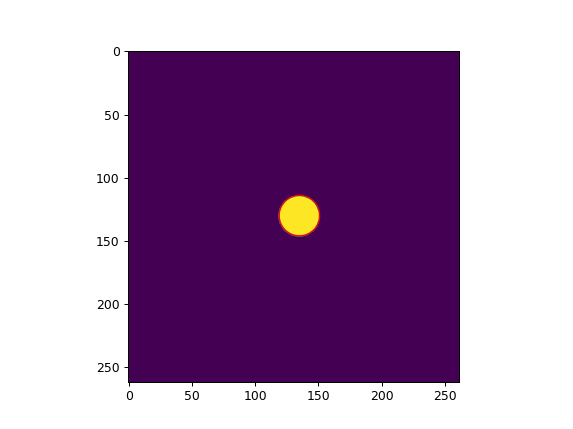

In [8]:
fig, axes = plt.subplots()
axes.imshow(np.abs(complex_waves[0, 0]))
circ_a = plt.Circle((cx, cy), semiconv_pix, fill=False, color='red')
axes.add_artist(circ_a)

In [9]:
plane_wave = complex_waves[:, :, cy, cx]

In [10]:
print(f"Abs: {np.abs(plane_wave[0,0])}")
print(f"Angle: {np.angle(plane_wave[0,0])}")

Abs: 36.05551275463989
Angle: 0.982793723247329


In [11]:
executor = InlineJobExecutor()
ctx = api.Context(executor=executor)
# async_executor = AsyncAdapter(executor)
# ctx = api.Context()

In [12]:
# set_use_cuda(0)
# set_use_cpu(0)

In [13]:
# ctx.executor.client.scheduler_info()

In [14]:
ds = ctx.load("memory", data=pixelated_stem, sig_dims=2)

In [15]:
dtype = np.float64
reconstruct_shape = ds.shape[:2]

In [16]:
%%time
%autoreload

masks_shift = generate_masks(
    reconstruct_shape=reconstruct_shape,
    mask_shape=shape[2:],
    dtype=dtype,
    lamb=wavelength(U),
    dpix=dpix,
    semiconv=semiconv,
    semiconv_pix=semiconv_pix,
    center=(cy, cx),
    transformation=transformation,
    cutoff=1,
    method='shift'
)

if get_device_class() == 'cuda':
    backend = 'cupy'
else:
    backend = 'numpy'

mask_container_shift = MaskContainer(
    mask_factories=lambda: masks_shift, dtype=masks_shift.dtype,
    use_sparse='scipy.sparse.csc', count=masks_shift.shape[0], backend=backend,
)

CPU times: user 5.88 s, sys: 43.7 ms, total: 5.92 s
Wall time: 5.96 s


<IPython.core.display.Javascript object>


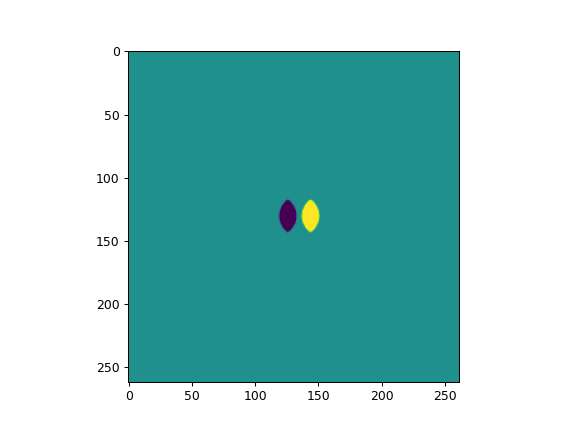

In [17]:
fig, axes = plt.subplots()
axes.imshow(masks_shift[1].todense())

In [18]:
%autoreload
udf_shift = SSB_UDF(
    U=U, dpix=dpix, semiconv=semiconv, semiconv_pix=semiconv_pix,
    dtype=dtype, center=(cy, cx), transformation=transformation,
    mask_container=mask_container_shift, cutoff=1
)

In [19]:
%%time
udf_result_shift = ctx.run_udf(udf=udf_shift, dataset=ds)

CPU times: user 7.57 s, sys: 2.63 s, total: 10.2 s
Wall time: 6.43 s


In [31]:
%autoreload
rec = get_results(udf_result_shift)

ssb_phase = np.angle(rec[0, 0])
ctem_phase = np.angle(plane_wave[0, 0])

ssb_amp = np.abs(rec[0, 0])
ctem_amp = np.abs(plane_wave[0, 0])

print(f"Phase: {ssb_phase}, {ctem_phase}")
print(f"Amp: {np.sqrt(ssb_amp)}, {ctem_amp}, factor {np.sqrt(ssb_amp)/ctem_amp}")
print(f"Amp: {ssb_amp}, {ctem_amp}, factor {ssb_amp/ctem_amp}")

Phase: 1.9392051604687767e-16, 0.982793723247329
Amp: 5.9549102621451775, 36.05551275463989, factor 0.16515949454577802
Amp: 35.460956230201944, 36.05551275463989, factor 0.983509968961364
